In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize_scalar
from scipy.integrate import quad
import seaborn as sns
from scipy.interpolate import interp1d
from matplotlib.ticker import PercentFormatter

import importlib

plt.rcParams['figure.figsize'] = (6.4, 4.8)
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.dpi'] = 75

inputs: 

operational cost of adding new manager

manager expected return
manager volatility
manager regime return

correlation structure

correlation regimes

can't add leverage but can reduce manager sizes


high volatility regime

regime probabilities

regime means

objective function: maximizing probability of exceeding total return threshold, conditional return threshold

Sharpe ratio assumption of 0.5

what parameters would we need to assume to get what we have now?

**formulate in terms of optimal shrinkage?**


In [3]:
import num_managers

importlib.reload(num_managers)

from num_managers import PortfolioDist, PortfolioMixtureDist, ManagerEvaluator

In [282]:
def linear_min_func(x, slope, mini):
    return np.maximum(x * slope, mini)

def core_mean_func(x, slope, strike, mini):
    return 

def solve_for_strike(slope, mini, mean):
    return 1 - np.sqrt(2 * (mean - mini) / slope)

def solve_for_slope(strike, mini, mean):
    return 2 * (mean - mini) / np.power(1 - strike, 2)


def get_mean_func(mini, mean, strike = None, slope = None):
    
    if strike is None:
        strike = solve_for_strike(slope, mini, mean)
        
    if slope is None:
        slope = solve_for_slope(strike, mini, mean)
        
    return lambda x: np.maximum(slope * (x - strike) + mini, mini)
    
    
def norm_geometric_dist(n, p):
    if p == 0:
        return np.ones_like(n) / n.shape[0]
    
    geo = np.power(1 - p, n) * p
    return geo / np.sum(geo)


def sample_means(rng, mean_func, picking_skill = 1e-3, universe_size = 20, n = 500):
    # sampling without replacement
    
    # picking best first
    manager_quantiles = np.linspace(1, 0, universe_size)
    manager_means = mean_func(manager_quantiles)
    
    geo_prob = norm_geometric_dist(np.arange(universe_size), picking_skill)
    portfolio_means = np.zeros((n, universe_size))
    
    
    for i in range(n):
        for j in range(1, universe_size + 1):
            chosen_means = rng.choice(manager_means, p = geo_prob, replace = False, size = j)
            portfolio_means[i, j-1] = np.mean(chosen_means)
    
    return portfolio_means

In [303]:
f = get_mean_func(0.04, 0.07, slope = 0.07)
rng = np.random.default_rng(seed = None)

x = np.arange(1, 20 + 1)

#MEANS_0 = sample_means(rng, f, picking_skill = 0)
MEANS_1 = sample_means(rng, f, picking_skill = 1e-1)


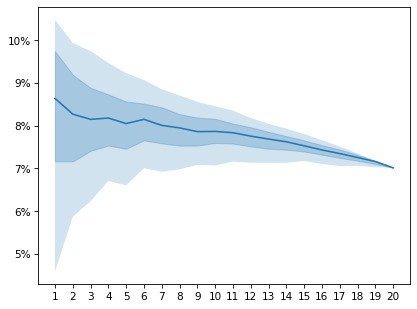

In [304]:
f, ax = plt.subplots()

ax.plot(x, np.median(MEANS_1, axis = 0))

ax.fill_between(x, np.quantile(MEANS_1, q = 0.95, axis = 0),
                   np.quantile(MEANS_1, q = 0.05, axis = 0), alpha = 0.2)

ax.fill_between(x, np.quantile(MEANS_1, q = 0.75, axis = 0),
                   np.quantile(MEANS_1, q = 0.25, axis = 0), alpha = 0.25, color = "tab:blue")


ax.set_xticks(x)
ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1, decimals = 0))

plt.show()

In [91]:
def mean_decay_func(initial_mean, n, decay_rate = 0.1, mean_pct_floor = 0):
    index = np.arange(n)
    return np.maximum(initial_mean * (1 - decay_rate) ** index, initial_mean * mean_pct_floor)

Conviction Decay Function

$$ \mu (1 - \theta)^i$$

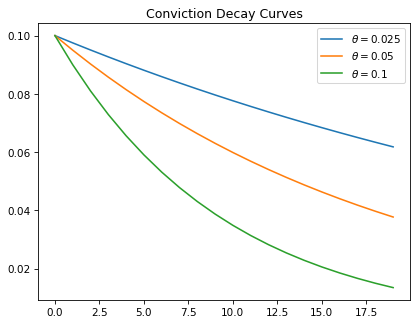

In [92]:
f, ax = plt.subplots()

ax.plot(mean_decay_func(0.1, 20, 0.025), label = r"$\theta = 0.025$")
ax.plot(mean_decay_func(0.1, 20, 0.05), label = r"$\theta = 0.05$")
ax.plot(mean_decay_func(0.1, 20, 0.1), label = r"$\theta = 0.1$")
ax.set_title("Conviction Decay Curves")
ax.legend()

Regime 1 (normal): low vol, low correlations, low returns, no crisis

Regime 2 (systematic crisis): high vol, high correlations, higher returns, crisis

Regime 3 (idiosyncratic crisis): high vol, low correlations, higher returns, crisis

Regime 4: (reversal): high vol, high correlations, low returns, no crisis


In [296]:
vols = np.array([0.15, 0.2])
p = np.array([0.8, 0.2])
sharpes = np.array([0.5, 0.5])
corrs = np.array([0.25, 0.75])
crisis_flags = np.array([0, 1])

mean_decay_rate = 0.05
mean_pct_floor = 0.5

In [297]:
m1 = ManagerEvaluator(p, vols, sharpes, corrs, crisis_flags, 
                      mean_decay_rate = mean_decay_rate, mean_pct_floor = mean_pct_floor)

In [298]:
results1 = m1.evaluate(1)
results2 = m1.evaluate(2)
results3 = m1.evaluate(3)
results4 = m1.evaluate(4)
results5 = m1.evaluate(5)
results6 = m1.evaluate(6)
results7 = m1.evaluate(7)
results8 = m1.evaluate(8)

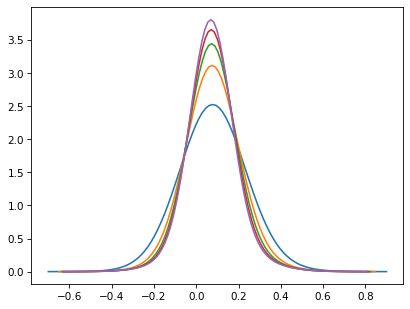

In [299]:
f, ax = plt.subplots()
ax.plot(results1["Dist"].x_range, results1["Dist"].pdf())
ax.plot(results2["Dist"].x_range, results2["Dist"].pdf())
ax.plot(results3["Dist"].x_range, results3["Dist"].pdf())
ax.plot(results4["Dist"].x_range, results4["Dist"].pdf())
ax.plot(results5["Dist"].x_range, results5["Dist"].pdf())

In [300]:
results1["Dist"].stats()

{'Ann. Mean': 0.08,
 'Ann. Std': 0.16155494421403513,
 'Sharpe': 0.4951875684721383,
 'Skew': 0.050159085599500323,
 'Kurtosis': 0.225044406276123}

In [301]:
results2["Dist"].stats()

{'Ann. Mean': 0.078,
 'Ann. Std': 0.13544394597027953,
 'Sharpe': 0.5758839898028041,
 'Skew': 0.09914931266567265,
 'Kurtosis': 0.6465460804809045}

In [302]:
results3["Dist"].stats()

{'Ann. Mean': 0.07606666666666667,
 'Ann. Std': 0.1255271885666386,
 'Sharpe': 0.6059776175603994,
 'Skew': 0.1280423634876147,
 'Kurtosis': 0.9717560132265919}

In [303]:
results4["Dist"].stats()

{'Ann. Mean': 0.07419750000000001,
 'Ann. Std': 0.12025398050884908,
 'Sharpe': 0.6170066029085837,
 'Skew': 0.14568888829915624,
 'Kurtosis': 1.2117599206448117}

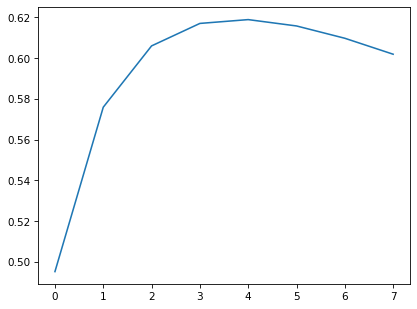

In [305]:
all_results = [results1, results2, results3, results4, results5, results6, results7, results8]

prob = [r["Dist"].stats()["Sharpe"] for r in all_results]

plt.plot(prob)